## Pretrained VisualBERT on evaluating the test labels

### Load the datasets, dataset cleaning and filtering
###### Data labelling for train and val dataset, load XLm-RoBERTa and CLIP
###### Obtain the vit features
###### Handling dimension issue
###### Fuse both text and visual features
###### text embeddings and the projected visual features are fed into a VisualBERT model
###### Evaluate the predictions for test dataset
###### Save the best models and metrics

In [ ]:
#!/usr/bin/env python3
"""
OPTIMIZED HATE SPEECH DETECTION PIPELINE
========================================
XLM-RoBERTa + CLIP + Pre-trained VisualBERT
"""

import os
import sys
import gc
import warnings
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from tqdm.auto import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Force minimal PyTorch import
def safe_torch_import():
    try:
        import torch
        import torch.nn as nn
        import torch.nn.functional as F
        from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
        from torch.optim import AdamW
        print(f"PyTorch {torch.__version__} loaded")
        return torch, nn, F, Dataset, DataLoader, WeightedRandomSampler, AdamW
    except Exception as e:
        print(f"Installing PyTorch...")
        subprocess.run([sys.executable, "-m", "pip", "install", "torch", "torchvision", "--break-system-packages"], check=True)
        import torch
        import torch.nn as nn
        import torch.nn.functional as F
        from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
        from torch.optim import AdamW
        return torch, nn, F, Dataset, DataLoader, WeightedRandomSampler, AdamW

torch, nn, F, Dataset, DataLoader, WeightedRandomSampler, AdamW = safe_torch_import()

# Minimal transformers import
try:
    from transformers import XLMRobertaTokenizer, XLMRobertaModel, BertTokenizer, VisualBertModel, VisualBertConfig
    print("Transformers, XLM-RoBERTa and VisualBERT loaded")
except ImportError:
    subprocess.run([sys.executable, "-m", "pip", "install", "transformers", "--break-system-packages"], check=True)
    from transformers import XLMRobertaTokenizer, XLMRobertaModel, BertTokenizer, VisualBertModel, VisualBertConfig

# Try to install and import CLIP
try:
    import clip
    print("CLIP already available")
except ImportError:
    print("Installing CLIP...")
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "git+https://github.com/openai/CLIP.git", "--break-system-packages"],
                      check=True, capture_output=True)
        import clip
        print("CLIP installed successfully")
    except Exception as e:
        print(f"CLIP installation failed: {e}, will use dummy features")


class MinimalConfig:
    NUM_CLASSES = 2
    MAX_TEXT_LENGTH = 128  # Increased for better text understanding
    BATCH_SIZE = 8  # Increased for stable gradients
    NUM_EPOCHS = 12  # Increased for better learning with regularization
    LEARNING_RATE = 1e-5  # Reduced to prevent overfitting
    HIDDEN_SIZE = 768
    VISUAL_DIM = 2048  # VisualBERT pre-trained expects 2048-dim visual features
    CLIP_DIM = 512
    VISUALBERT_MODEL = "uclanlp/visualbert-vqa-coco-pre"  # Pre-trained model

    WEIGHT_DECAY = 0.01  # L2 regularization
    GRADIENT_CLIP_NORM = 1.0  # Gradient clipping
    EARLY_STOPPING_PATIENCE = 3  # Early stopping
    DROPOUT_RATE = 0.3  # Increased dropout

config = MinimalConfig()

def mount_drive():
    """Mount Google Drive"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Drive mounted!")
    except:
        pass

def create_labels(df):
    """Create labels from offensive column with validation"""
    hate_categories = ['offensive', 'very_offensive', 'slight', 'hateful_offensive']

    print(f"Original 'offensive' column unique values: {df['offensive'].unique()}")

    # Create binary labels
    df['label'] = df['offensive'].apply(lambda x: 1 if x in hate_categories else 0)

    # Validate created labels
    unique_labels = df['label'].unique()
    print(f"Created labels unique values: {unique_labels}")

    # Ensure only 0 and 1
    if not all(label in [0, 1] for label in unique_labels):
        print(f"ERROR: Invalid labels created: {unique_labels}")
        # Force binary conversion
        df['label'] = df['label'].astype(int)
        df['label'] = df['label'].apply(lambda x: 1 if x > 0 else 0)
        print(f"After forced conversion: {df['label'].unique()}")

    return df

def calculate_dynamic_class_weights(labels, strategy='balanced'):
    """
    Calculate dynamic class weights based on dataset characteristics
    """
    unique_labels, counts = np.unique(labels, return_counts=True)

    if strategy == 'balanced':
        # Standard balanced weights: n_samples / (n_classes * np.bincount(y))
        n_samples = len(labels)
        n_classes = len(unique_labels)
        weights = n_samples / (n_classes * counts)
    elif strategy == 'sqrt':
        # Square root of inverse frequency (less aggressive)
        total = len(labels)
        weights = np.sqrt(total / counts)
    elif strategy == 'log':
        # Logarithmic scaling (even less aggressive)
        total = len(labels)
        weights = np.log(total / counts + 1)
    elif strategy == 'focal':
        # Focal loss inspired weights (for very imbalanced data)
        total = len(labels)
        alpha = 0.25  # Focus on minority class
        weights = np.where(counts < total * 0.1, alpha, 1 - alpha) * (total / counts)
    elif strategy == 'moderate':
        # More moderate weighting to prevent overfitting
        total = len(labels)
        imbalance_ratio = np.max(counts) / np.min(counts)
        print(f"Imbalance ratio: {imbalance_ratio:.2f}")
        if imbalance_ratio > 1.2:  # Lowered threshold to detect moderate imbalance
            # Use sqrt for imbalance to avoid extreme weights
            weights = np.sqrt(total / counts)
            weights = weights / np.mean(weights)  # Normalize
            weights = (weights + 1) / 2  # Moderate the weights (reduce by half)
            print(f"Applied moderate sqrt weighting")
        else:
            weights = np.ones(len(unique_labels))
            print(f"No imbalance detected, using equal weights")
    else:
        # Equal weights
        weights = np.ones(len(unique_labels))

    # Clip extreme weights to prevent overfitting
    weights = np.clip(weights, 0.1, 5.0)

    # Create weight dictionary
    weight_dict = dict(zip(unique_labels, weights))

    print(f"Class distribution: {dict(zip(unique_labels, counts))}")
    print(f"Class weights ({strategy}): {weight_dict}")

    return weight_dict

def find_optimal_threshold(y_true, y_probs):
    """Find optimal threshold for imbalanced classification"""
    from sklearn.metrics import precision_recall_curve, f1_score

    # Method 1: Best F1 score
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Optimal threshold for F1: {best_threshold:.3f} (F1: {best_f1:.3f})")
    return best_threshold

def load_and_process_data(file_path, dataset_name, sample_size=None):
    """Load and process data with specified sample sizes"""
    print(f"Loading {dataset_name}...")

    try:
        # Special handling for validation data (tab-delimited)
        if 'val' in dataset_name.lower():
            df = pd.read_csv(file_path, delimiter='\t')
            print(f"Loaded {dataset_name} with tab delimiter")
        else:
            # Try comma first, then tab
            try:
                df = pd.read_csv(file_path, delimiter=',')
                print(f"Loaded {dataset_name} with comma delimiter")
            except:
                df = pd.read_csv(file_path, delimiter='\t')
                print(f"Loaded {dataset_name} with tab delimiter")

        print(f"Total samples: {len(df)}")

        # Handle column mapping
        if 'Unnamed: 0' in df.columns:
            df['id'] = df['Unnamed: 0']
        elif 'id' not in df.columns:
            df['id'] = range(len(df))

        # Process labels with explicit validation
        if 'offensive' in df.columns:
            df = create_labels(df)
        elif 'label' not in df.columns:
            df['label'] = 0

        # CRITICAL: Validate all labels are 0 or 1
        if 'label' in df.columns:
            unique_labels = df['label'].unique()
            print(f"Dataset unique labels: {unique_labels}")

            # Check for invalid labels
            invalid_labels = [l for l in unique_labels if l not in [0, 1]]
            if invalid_labels:
                print(f"WARNING: Found invalid labels {invalid_labels}, converting to binary")
                # Convert any non-0 label to 1
                df['label'] = df['label'].apply(lambda x: 1 if x != 0 else 0)
                print(f"After conversion: {df['label'].unique()}")

            # Final validation
            final_unique = df['label'].unique()
            if not all(label in [0, 1] for label in final_unique):
                print(f"CRITICAL: Labels still invalid after conversion: {final_unique}")
                raise ValueError("Cannot proceed with invalid labels")
            else:
                print(f"All labels validated: {final_unique}")

        # Ensure required columns
        if 'image_url' not in df.columns:
            df['image_url'] = 'placeholder.jpg'
        if 'ocr' not in df.columns:
            df['ocr'] = 'placeholder text'

        # Keep only essential columns
        df = df[['id', 'image_url', 'ocr', 'label']].copy()

        # Apply sample size limit if specified
        if sample_size and len(df) > sample_size:
            df = df.head(sample_size).copy()
            print(f"Using {sample_size} samples")

        # Comprehensive data filtering and cleaning
        initial_count = len(df)
        print(f"Starting filtering with {initial_count} samples...")

        # 1. Basic text cleaning - allow longer text
        df['ocr'] = df['ocr'].astype(str).str[:512]

        # 2. Remove very short texts (less than 3 words)
        df = df[df['ocr'].str.split().str.len() >= 3]
        print(f"After short text removal: {len(df)} samples (-{initial_count - len(df)})")

        # 3. Remove very long texts (more than 100 words)
        df = df[df['ocr'].str.split().str.len() <= 100]
        print(f"After long text removal: {len(df)} samples")

        # 4. Remove duplicates based on OCR text
        df = df.drop_duplicates(subset=['ocr'], keep='first')
        print(f"After duplicate removal: {len(df)} samples")

        # 5. Remove texts with excessive repetition
        def has_excessive_repetition(text, max_repeats=3):
            words = text.lower().split()
            if len(words) <= 1:
                return False
            word_counts = {}
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1
                if word_counts[word] > max_repeats:
                    return True
            return False

        before_rep = len(df)
        df = df[~df['ocr'].apply(has_excessive_repetition)]
        print(f"After repetition removal: {len(df)} samples (-{before_rep - len(df)})")

        # 6. Remove texts with too many non-alphabetic characters
        def has_too_many_non_alpha(text, threshold=0.7):
            if len(text) == 0:
                return True
            alpha_chars = sum(1 for c in text if c.isalpha() or c.isspace())
            return (alpha_chars / len(text)) < threshold

        before_alpha = len(df)
        df = df[~df['ocr'].apply(has_too_many_non_alpha)]
        print(f"After non-alphabetic removal: {len(df)} samples (-{before_alpha - len(df)})")

        # 7. Text normalization
        def normalize_text(text):
            import re
            # Replace URLs
            text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', text)
            # Replace mentions
            text = re.sub(r'@\w+', '[MENTION]', text)
            # Replace hashtags
            text = re.sub(r'#\w+', '[HASHTAG]', text)
            # Multiple spaces to single space
            text = re.sub(r'\s+', ' ', text)
            return text.strip()

        df['ocr'] = df['ocr'].apply(normalize_text)

        # 8. Data augmentation for single class handling
        if len(df['label'].unique()) == 1:

            minority_class = 1 - df['label'].iloc[0]  # Opposite class

            # Create synthetic samples by simple text modifications
            synthetic_samples = []
            original_texts = df['ocr'].tolist()[:min(100, len(df)//4)]  # Max 100 synthetic samples

            for text in original_texts:
                # Simple augmentation
                aug_text = f"not {text}" if minority_class == 1 else text.replace("not ", "")
                synthetic_samples.append({
                    'id': f"synthetic_{len(synthetic_samples)}",
                    'image_url': 'placeholder.jpg',
                    'ocr': aug_text,
                    'label': minority_class
                })

            if synthetic_samples:
                synthetic_df = pd.DataFrame(synthetic_samples)
                df = pd.concat([df, synthetic_df], ignore_index=True)
                print(f"Added {len(synthetic_samples)} synthetic samples for class {minority_class}")

        print(f"Final filtering results: {len(df)} samples (removed {initial_count - len(df)})")
        print(f"Final label distribution: {dict(df['label'].value_counts()) if 'label' in df.columns else 'No labels'}")
        return df

    except Exception as e:
        print(f"ERROR loading {dataset_name}: {e}")
        print(f"   File path: {file_path}")
        print(f"   File exists: {os.path.exists(file_path)}")
        if os.path.exists(file_path):
            try:
                # Try to show first few lines for debugging
                with open(file_path, 'r') as f:
                    lines = f.readlines()[:3]
                    print(f"   First few lines: {lines}")
            except:
                pass
        return pd.DataFrame()

def create_clip_features(df, cache_file=None):
    """Create real CLIP features from image URLs with caching"""
    num_samples = len(df)

    # Check cache first
    if cache_file and os.path.exists(cache_file):
        try:
            cached_features = np.load(cache_file)
            if cached_features.shape[0] == num_samples:
                print(f"Loaded CLIP features from cache: {cached_features.shape}")
                return cached_features
        except Exception as e:
            print(f"Cache loading failed: {e}")

    # Try to use  CLIP
    try:
        import clip
        import torch
        from PIL import Image
        import requests
        from io import BytesIO

        device = "cuda" if torch.cuda.is_available() else "cpu"
        model, preprocess = clip.load("ViT-B/32", device=device)

        clip_features = []
        successful_extractions = 0
        print(f"Extracting CLIP features for {num_samples} samples...")

        for i, (idx, row) in enumerate(df.iterrows()):
            try:
                # Try to load and process image from URL
                image_url = row.get('image_url', '')
                if image_url and image_url != 'placeholder.jpg' and 'http' in str(image_url):
                    # Try to download and process image
                    response = requests.get(image_url, timeout=10, headers={'User-Agent': 'Mozilla/5.0'})
                    if response.status_code == 200:
                        image = Image.open(BytesIO(response.content)).convert('RGB')
                        image_input = preprocess(image).unsqueeze(0).to(device)

                        with torch.no_grad():
                            features = model.encode_image(image_input)
                            features = features.cpu().numpy().flatten()
                            clip_features.append(features)
                            successful_extractions += 1
                    else:
                        clip_features.append(np.zeros(config.CLIP_DIM, dtype=np.float32))
                else:
                    # Use zero features for missing/invalid URLs
                    clip_features.append(np.zeros(config.CLIP_DIM, dtype=np.float32))

            except Exception as e:
                # Fallback to zero features for failed downloads
                clip_features.append(np.zeros(config.CLIP_DIM, dtype=np.float32))

            # Progress update - use enumerate counter instead of idx
            if (i + 1) % 50 == 0:
                print(f"Processed {i + 1}/{num_samples} images ({successful_extractions} successful)")

        clip_features = np.array(clip_features, dtype=np.float32)
        print(f"CLIP features extracted: {clip_features.shape} ({successful_extractions}/{num_samples} successful)")

        # Save to cache
        if cache_file:
            try:
                np.save(cache_file, clip_features)
                print(f"CLIP features cached to {cache_file}")
            except Exception as e:
                print(f"Caching failed: {e}")

        return clip_features

    except Exception as e:
        print(f"CLIP not available ({e}), using dummy features")
        # Fallback to dummy features
        clip_features = np.random.randn(num_samples, config.CLIP_DIM).astype(np.float32)
        clip_features = clip_features / (np.linalg.norm(clip_features, axis=1, keepdims=True) + 1e-8)
        return clip_features

def create_visual_features_for_pretrained_visualbert(clip_features):
    """
    Create visual features
    Pre-trained VisualBERT expects 2048-dim visual features (object detection features)
    """
    num_samples = clip_features.shape[0]

    # Create 2048-dim features from CLIP features (512-dim)
    visual_features = np.zeros((num_samples, config.VISUAL_DIM), dtype=np.float32)

    # Method: Repeat CLIP features to fill 2048 dimensions intelligently
    clip_repeats = config.VISUAL_DIM // config.CLIP_DIM  # 2048 // 512 = 4

    for i in range(clip_repeats):
        start_idx = i * config.CLIP_DIM
        end_idx = (i + 1) * config.CLIP_DIM

        if i == 0:
            # First copy: original CLIP features
            visual_features[:, start_idx:end_idx] = clip_features
        else:
            # Subsequent copies: add small variations
            noise_factor = 0.05 * i  # Increasing noise for each repetition
            noise = np.random.normal(0, noise_factor, clip_features.shape).astype(np.float32)
            visual_features[:, start_idx:end_idx] = clip_features + noise

    # Handle any remaining dimensions
    remaining_dims = config.VISUAL_DIM % config.CLIP_DIM
    if remaining_dims > 0:
        visual_features[:, -remaining_dims:] = clip_features[:, :remaining_dims]

    # Normalize the features
    visual_features = visual_features / (np.linalg.norm(visual_features, axis=1, keepdims=True) + 1e-8)

    print(f"Created VisualBERT-compatible features from CLIP: {visual_features.shape}")
    return visual_features

class MinimalDataset(Dataset):
    """Dataset with CLIP + VisualBERT features"""

    def __init__(self, df, clip_features, visual_features, xlm_tokenizer, bert_tokenizer):
        self.texts = df['ocr'].tolist()
        self.labels = df['label'].tolist()
        self.clip_features = clip_features
        self.visual_features = visual_features
        self.xlm_tokenizer = xlm_tokenizer
        self.bert_tokenizer = bert_tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Robust label conversion with explicit safeguards
        try:
            label = int(self.labels[idx])
            # Ensure label is exactly 0 or 1 for binary classification
            if label not in [0, 1]:
                print(f"WARNING: Invalid label {label} at index {idx}, converting to 0")
                print(f"Original label value: {self.labels[idx]}, type: {type(self.labels[idx])}")
                label = 0  # Fallback to class 0
        except (ValueError, TypeError) as e:
            print(f"ERROR: Could not convert label to int at index {idx}: {self.labels[idx]}")
            print(f"Label type: {type(self.labels[idx])}, error: {e}")
            label = 0  # Fallback to class 0

        # Tokenization with XLM-RoBERTa (for main text processing) with enhanced debugging
        try:
            # Clean text first
            text = str(text).strip()
            if not text or len(text) < 1:
                text = "placeholder text"

            encoding = self.xlm_tokenizer(
                text,
                max_length=config.MAX_TEXT_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                add_special_tokens=True
            )

            # Simplified BERT tokenization (for compatibility)
            bert_encoding = self.bert_tokenizer(
                text,
                max_length=config.MAX_TEXT_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                add_special_tokens=True
            )

            # Debug: Check for invalid token IDs
            max_token_id = self.xlm_tokenizer.vocab_size - 1
            if torch.any(encoding['input_ids'] > max_token_id) or torch.any(encoding['input_ids'] < 0):
                print(f"WARNING: Invalid XLM token IDs detected")
                encoding['input_ids'] = torch.clamp(encoding['input_ids'], 0, max_token_id)

            bert_max_token_id = self.bert_tokenizer.vocab_size - 1
            if torch.any(bert_encoding['input_ids'] > bert_max_token_id) or torch.any(bert_encoding['input_ids'] < 0):
                print(f"WARNING: Invalid BERT token IDs detected")
                bert_encoding['input_ids'] = torch.clamp(bert_encoding['input_ids'], 0, bert_max_token_id)

        except Exception as e:
            print(f"Tokenization error: {e}")
            # Fallback for problematic text
            encoding = self.xlm_tokenizer(
                "placeholder text",
                max_length=config.MAX_TEXT_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                add_special_tokens=True
            )
            bert_encoding = self.bert_tokenizer(
                "placeholder text",
                max_length=config.MAX_TEXT_LENGTH,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                add_special_tokens=True
            )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'bert_input_ids': bert_encoding['input_ids'].squeeze(0),
            'bert_attention_mask': bert_encoding['attention_mask'].squeeze(0),
            'clip_features': torch.FloatTensor(self.clip_features[idx]),
            'visual_features': torch.FloatTensor(self.visual_features[idx]),
            'labels': torch.LongTensor([label])
        }

class XLMRobertaCLIPVisualBertModel(nn.Module):
    """XLM-RoBERTa + CLIP + Pre-trained VisualBERT model with optimizations"""

    def __init__(self, class_weights=None):
        super().__init__()
        # XLM-RoBERTa for text encoding
        self.xlm_roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base")

        # Unfreeze more layers for better learning
        for param in self.xlm_roberta.embeddings.parameters():
            param.requires_grad = False
        for layer in self.xlm_roberta.encoder.layer[:-4]:  # Train last 4 layers
            for param in layer.parameters():
                param.requires_grad = False

        # CLIP feature projection
        self.clip_proj = nn.Linear(config.CLIP_DIM, config.HIDDEN_SIZE)

        # Pre-trained VisualBERT initialization with CUDA fixes
        try:
            print(f"Loading pre-trained VisualBERT: {config.VISUALBERT_MODEL}")

            # Load VisualBERT with explicit settings to avoid CUDA issues
            self.visual_bert = VisualBertModel.from_pretrained(
                config.VISUALBERT_MODEL,
                torch_dtype=torch.float32,
                device_map=None,  # Manual device placement
                output_hidden_states=False,
                output_attentions=False
            )

            # Freeze most layers to prevent training issues
            for param in self.visual_bert.embeddings.parameters():
                param.requires_grad = False
            for layer in self.visual_bert.encoder.layer[:-2]:
                for param in layer.parameters():
                    param.requires_grad = False

            # Get visual embedding dimension from config
            if hasattr(self.visual_bert.config, 'visual_embedding_dim'):
                self.visual_embedding_dim = self.visual_bert.config.visual_embedding_dim
            else:
                # Fallback for models without this attribute
                self.visual_embedding_dim = 2048  # Standard VisualBERT dimension

            self.use_visualbert = True
            print(f"VisualBERT loaded! Visual embedding dim: {self.visual_embedding_dim}")

        except Exception as e:
            print(f"VisualBERT loading failed: {e}")
            print("Using fallback approach")
            self.visual_bert = None
            self.use_visualbert = False
            self.visual_embedding_dim = config.VISUAL_DIM

        # Create visual projections
        if self.use_visualbert:
            self.visual_feature_proj = nn.Linear(config.VISUAL_DIM, self.visual_embedding_dim)
            print(f"Visual projection: {config.VISUAL_DIM} -> {self.visual_embedding_dim}")
        else:
            self.visual_proj = nn.Linear(config.VISUAL_DIM, config.HIDDEN_SIZE)
            print(f"Fallback projection: {config.VISUAL_DIM} -> {config.HIDDEN_SIZE}")

        # REGULARIZED CLASSIFIER HEAD - Better regularization to prevent overfitting
        self.classifier = nn.Sequential(
            nn.Dropout(config.DROPOUT_RATE),  # Increased dropout
            nn.Linear(config.HIDDEN_SIZE * 2, config.HIDDEN_SIZE // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT_RATE * 0.5),  # Lighter dropout in middle
            nn.Linear(config.HIDDEN_SIZE // 2, config.NUM_CLASSES)
        )

        # Store class weights for loss calculation
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, bert_input_ids, bert_attention_mask, clip_features, visual_features, labels=None):
        # CLIP feature processing
        clip_proj = self.clip_proj(clip_features)

        if self.use_visualbert and self.visual_bert is not None:
            try:
                batch_size = input_ids.size(0)

                # Project visual features to VisualBERT dimension
                visual_embeds = self.visual_feature_proj(visual_features)
                visual_embeds = visual_embeds.unsqueeze(1)  # (batch_size, 1, visual_dim)

                # Create visual attention mask
                visual_attention_mask = torch.ones(
                    batch_size, 1,
                    device=bert_input_ids.device,
                    dtype=bert_attention_mask.dtype
                )

                # Ensure BERT tokens are in valid range
                vocab_size = self.visual_bert.config.vocab_size
                bert_input_ids_safe = torch.clamp(bert_input_ids, 0, vocab_size - 1)

                # VisualBERT forward pass with error handling
                visualbert_outputs = self.visual_bert(
                    input_ids=bert_input_ids_safe,
                    attention_mask=bert_attention_mask,
                    visual_embeds=visual_embeds,
                    visual_attention_mask=visual_attention_mask,
                    return_dict=True
                )

                text_visual_combined = visualbert_outputs.pooler_output

            except Exception as e:
                # Fallback to XLM-RoBERTa
                text_outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
                text_pooled = text_outputs.pooler_output
                visual_proj = self.visual_feature_proj(visual_features) if hasattr(self, 'visual_feature_proj') else visual_features[:, :config.HIDDEN_SIZE]
                text_visual_combined = text_pooled + visual_proj[:, :config.HIDDEN_SIZE]
        else:
            # Fallback: XLM-RoBERTa + simple visual projection
            text_outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
            text_pooled = text_outputs.pooler_output
            visual_proj = self.visual_proj(visual_features)
            text_visual_combined = text_pooled + visual_proj

        # Combine CLIP with text+visual features
        combined_features = torch.cat([clip_proj, text_visual_combined], dim=-1)

        # Direct classification with simplified head
        logits = self.classifier(combined_features)

        outputs = {'logits': logits}

        if labels is not None:
            # Use dynamic class weights
            if self.class_weights is not None:
                weight_tensor = torch.tensor(
                    [self.class_weights.get(i, 1.0) for i in range(config.NUM_CLASSES)],
                    device=logits.device,
                    dtype=torch.float32
                )
            else:
                weight_tensor = None

            # Ensure labels are in correct range [0, NUM_CLASSES-1] with debugging
            labels_flat = labels.squeeze(-1)

            # Explicit label validation to prevent CUDA errors
            labels_flat = labels.squeeze(-1)

            # Check for invalid labels that cause CUDA assertions
            unique_labels = torch.unique(labels_flat)
            invalid_labels = unique_labels[(unique_labels < 0) | (unique_labels >= config.NUM_CLASSES)]

            if len(invalid_labels) > 0:
                print(f"CRITICAL ERROR: Invalid labels detected that will cause CUDA crash!")
                print(f"Invalid labels: {invalid_labels.tolist()}")
                print(f"Valid range: [0, {config.NUM_CLASSES-1}]")
                print(f"All unique labels: {unique_labels.tolist()}")
                print(f"Labels shape: {labels_flat.shape}")
                print(f"Logits shape: {logits.shape}")

            # Force clamp labels to valid range
            labels_flat = torch.clamp(labels_flat, 0, config.NUM_CLASSES - 1)

            # Double-check after clamping
            if torch.any(labels_flat < 0) or torch.any(labels_flat >= config.NUM_CLASSES):
                print(f"FATAL: Labels still invalid after clamping! This will crash CUDA.")
                print(f"Post-clamp labels: {torch.unique(labels_flat).tolist()}")
                raise ValueError("Cannot proceed with invalid labels")

            # Debug: Check logits shape
            if logits.size(-1) != config.NUM_CLASSES:
                print(f"WARNING: Logits shape mismatch. Expected {config.NUM_CLASSES}, got {logits.size(-1)}")

            try:
                loss_fn = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=0.0)  # Remove label smoothing
                loss = loss_fn(logits, labels_flat)
            except Exception as e:
                print(f"Loss calculation error: {e}")
                print(f"Logits shape: {logits.shape}, Labels shape: {labels_flat.shape}")
                print(f"Logits range: [{logits.min():.3f}, {logits.max():.3f}]")
                print(f"Labels unique: {labels_flat.unique()}")
                # Fallback loss
                loss = torch.tensor(0.0, device=logits.device, requires_grad=True)
            outputs['loss'] = loss

        return outputs

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train one epoch with regularization"""
    model.train()
    total_loss = 0
    total_acc = 0
    num_batches = 0

    for batch in tqdm(dataloader, desc="Training"):
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            bert_input_ids = batch['bert_input_ids'].to(device)
            bert_attention_mask = batch['bert_attention_mask'].to(device)
            clip_features = batch['clip_features'].to(device)
            visual_features = batch['visual_features'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask, bert_input_ids, bert_attention_mask, clip_features, visual_features, labels)
            loss = outputs['loss']
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP_NORM)

            optimizer.step()
            scheduler.step()  # Update learning rate

            # Calculate accuracy with balanced threshold
            with torch.no_grad():
                probs = torch.softmax(outputs['logits'], dim=-1)
                threshold = 0.5  # Will be optimized later
                predictions = (probs[:, 1] > threshold).long()
                labels_flat = torch.clamp(labels.squeeze(-1), 0, config.NUM_CLASSES - 1)
                accuracy = (predictions == labels_flat).float().mean()

            total_loss += loss.item()
            total_acc += accuracy.item()
            num_batches += 1

            # Clear cache frequently
            if num_batches % 10 == 0:
                torch.cuda.empty_cache() if device.type == 'cuda' else None

        except Exception as e:
            print(f"Batch error: {e}")
            continue

    return total_loss / max(num_batches, 1), total_acc / max(num_batches, 1)

def evaluate(model, dataloader, device, threshold=0.5, return_loss=False):
    """Evaluate model and return all predictions for detailed metrics - MODIFIED to include loss tracking"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                bert_input_ids = batch['bert_input_ids'].to(device)
                bert_attention_mask = batch['bert_attention_mask'].to(device)
                clip_features = batch['clip_features'].to(device)
                visual_features = batch['visual_features'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask, bert_input_ids, bert_attention_mask, clip_features, visual_features, labels)
                logits = outputs['logits']

                # Track validation loss
                if return_loss and 'loss' in outputs:
                    total_loss += outputs['loss'].item()
                    num_batches += 1

                # Use provided threshold with bounds checking
                probs = torch.softmax(logits, dim=-1)
                predictions = (probs[:, 1] > threshold).long()
                labels_flat = torch.clamp(labels.squeeze(-1), 0, config.NUM_CLASSES - 1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels_flat.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())

            except Exception as e:
                continue

    if not all_predictions:
        if return_loss:
            return 0.0, 0.0, [], [], [], 0.0
        else:
            return 0.0, 0.0, [], [], []

    accuracy = accuracy_score(all_labels, all_predictions)

    try:
        auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    except:
        auc = 0.5

    if return_loss:
        avg_loss = total_loss / max(num_batches, 1)
        return accuracy, auc, all_labels, all_predictions, all_probs, avg_loss
    else:
        return accuracy, auc, all_labels, all_predictions, all_probs

def compute_comprehensive_metrics(y_true, y_pred, y_prob=None):
    """Compute all metrics: accuracy, auc, precision, recall, f1"""
    from sklearn.metrics import precision_score, recall_score, f1_score

    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 for both classes
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    metrics['precision_class_0'] = precision[0] if len(precision) > 0 else 0
    metrics['precision_class_1'] = precision[1] if len(precision) > 1 else 0
    metrics['recall_class_0'] = recall[0] if len(recall) > 0 else 0
    metrics['recall_class_1'] = recall[1] if len(recall) > 1 else 0
    metrics['f1_class_0'] = f1[0] if len(f1) > 0 else 0
    metrics['f1_class_1'] = f1[1] if len(f1) > 1 else 0

    # Macro and weighted averages
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

    metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # AUC
    if y_prob is not None and len(set(y_true)) > 1:
        try:
            metrics['auc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['auc'] = 0.5
    else:
        metrics['auc'] = 0.5

    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return metrics

def print_comprehensive_results(metrics, model_name="Model"):
    """Print all metrics in a clean format"""
    print(f"\n{model_name} Results:")
    print("=" * 50)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"Precision (Class 0): {metrics['precision_class_0']:.4f}")
    print(f"Precision (Class 1): {metrics['precision_class_1']:.4f}")
    print(f"Recall (Class 0): {metrics['recall_class_0']:.4f}")
    print(f"Recall (Class 1): {metrics['recall_class_1']:.4f}")
    print(f"F1-Score (Class 0): {metrics['f1_class_0']:.4f}")
    print(f"F1-Score (Class 1): {metrics['f1_class_1']:.4f}")
    print(f"Macro Precision: {metrics['precision_macro']:.4f}")
    print(f"Macro Recall: {metrics['recall_macro']:.4f}")
    print(f"Macro F1-Score: {metrics['f1_macro']:.4f}")
    print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
    print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
    print(f"Weighted F1-Score: {metrics['f1_weighted']:.4f}")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])

def main():
    """Optimized main function"""
    # Set CUDA debugging FIRST - before any CUDA operations
    import os
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['TORCH_USE_CUDA_DSA'] = '1'  # Enable device-side assertions

    print("=" * 50)
    print("OPTIMIZED HATE SPEECH PIPELINE")
    print("XLM-RoBERTa + CLIP + Pre-trained VisualBERT")
    print("=" * 50)
    print("CUDA debugging enabled with synchronous error reporting")

    # Mount drive
    mount_drive()

    # Device setup - FORCE CUDA usage
    if not torch.cuda.is_available():
        print("ERROR: CUDA not available!")
        return None

    device = torch.device('cuda')
    print(f"Using device: {device}")

    # Force memory cleanup
    gc.collect()
    try:
        torch.cuda.empty_cache()
        print("CUDA cache cleared successfully")
    except Exception as e:
        print(f"CUDA cache clear failed: {e}")
        # Continue anyway - this error might be from previous runs
        print("Continuing with CUDA anyway...")

    # Load data with specified sample sizes
    print("\nLOADING DATA")
    print("-" * 40)
    print("Using: 4000 train, 1000 val, 1000 test samples")

    # Debug: Check if files exist
    train_path = "/content/drive/MyDrive/Memotion3/train.csv"
    val_path = "/content/drive/MyDrive/Memotion3/val.csv"
    test_path = "/content/drive/MyDrive/Memotion3/test_with_labels.csv"

    print(f"File existence check:")
    print(f"   Train: {os.path.exists(train_path)} - {train_path}")
    print(f"   Val:   {os.path.exists(val_path)} - {val_path}")
    print(f"   Test:  {os.path.exists(test_path)} - {test_path}")

    train_df = load_and_process_data(train_path, "Training", sample_size=4000)
    val_df = load_and_process_data(val_path, "Validation", sample_size=1000)
    test_df = load_and_process_data(test_path, "Test", sample_size=1000)

    if train_df.empty:
        print("ERROR: No training data loaded")
        return None

    print(f"\nData loading results:")
    print(f"   Training: {len(train_df)} samples")
    if val_df.empty:
        print(f"   Validation: 0 samples (EMPTY - will skip validation)")
    else:
        print(f"   Validation: {len(val_df)} samples")

    if test_df.empty:
        print(f"   Test: 0 samples (will skip test evaluation)")
    else:
        print(f"   Test: {len(test_df)} samples")

    # Create CLIP features first
    print("\nCREATING FEATURES")
    print("-" * 30)

    train_clip = create_clip_features(train_df, cache_file="train_clip_features.npy")
    # Use CLIP features to create VisualBERT-compatible features
    train_visual = create_visual_features_for_pretrained_visualbert(train_clip)

    if not val_df.empty:
        val_clip = create_clip_features(val_df, cache_file="val_clip_features.npy")
        val_visual = create_visual_features_for_pretrained_visualbert(val_clip)
        print(f"Created validation features: {len(val_df)} samples")
    else:
        val_clip = np.array([])
        val_visual = np.array([])
        print("No validation features created (empty validation data)")

    test_clip = create_clip_features(test_df, cache_file="test_clip_features.npy") if not test_df.empty else np.array([])
    test_visual = create_visual_features_for_pretrained_visualbert(test_clip) if not test_df.empty else np.array([])

    # Calculate dynamic class weights
    print("\nCALCULATING CLASS WEIGHTS")
    print("-" * 30)

    # Try different weighting strategies and choose the best one
    train_labels = train_df['label'].values
    strategies = ['balanced', 'sqrt', 'log', 'focal', 'moderate']

    weight_options = {}
    for strategy in strategies:
        weight_options[strategy] = calculate_dynamic_class_weights(train_labels, strategy)

    # For initial training, use 'moderate' strategy to prevent overfitting
    chosen_strategy = 'moderate'
    class_weights = weight_options[chosen_strategy]
    print(f"Selected strategy: {chosen_strategy}")

    # Initialize tokenizer and model
    print("\nINITIALIZING XLM-ROBERTA + CLIP + PRE-TRAINED VISUALBERT MODEL")
    print("-" * 60)

    try:
        # Use both tokenizers - XLM-RoBERTa for text processing, BERT for VisualBERT compatibility
        xlm_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
        bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = XLMRobertaCLIPVisualBertModel(class_weights=class_weights)
        model = model.to(device)

        if hasattr(model, 'visual_bert') and model.visual_bert is not None:
            model.visual_bert = model.visual_bert.to(device)

    except Exception as e:
        print(f"Model initialization failed: {e}")
        return None

    print("Model initialized with pre-trained VisualBERT and dynamic class weights")

    # Create datasets with balanced sampling
    train_dataset = MinimalDataset(train_df, train_clip, train_visual, xlm_tokenizer, bert_tokenizer)

    # Calculate sample weights for balanced training
    labels = train_df['label'].values
    class_counts = np.bincount(labels)
    sample_class_weights = np.array([class_weights[i] for i in range(len(class_weights))])
    sample_weights = sample_class_weights[labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        sampler=sampler,  # Use balanced sampler instead of shuffle
        num_workers=0
    )

    print(f"Class distribution: {dict(zip(range(len(class_counts)), class_counts))}")
    print(f"Applied class weights: {class_weights}")

    # Training setup with weight decay and learning rate scheduling
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

    # Learning rate scheduler - reduce LR when validation plateaus
    from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # MODIFIED: mode='min' for loss, removed verbose

    # Training with validation
    print("\nSTARTING REGULARIZED TRAINING WITH PRE-TRAINED VISUALBERT")
    print("-" * 50)

    best_acc = 0.0
    best_auc = 0.0
    patience_counter = 0
    best_val_f1 = 0.0
    best_val_loss = float('inf')  #  Track best validation loss

    # Create validation loader if available
    val_loader = None
    if not val_df.empty:
        val_dataset = MinimalDataset(val_df, val_clip, val_visual, xlm_tokenizer, bert_tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

    #  Track training history for monitoring convergence
    train_losses = []
    val_losses = []
    val_accs = []
    val_aucs = []

    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{config.NUM_EPOCHS}")

        # Force cleanup before each epoch
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Training with step scheduler (for gradient clipping)
        step_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: 1.0)
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, step_scheduler, device)

        # Get training AUC as well
        train_acc_eval, train_auc, _, _, _ = evaluate(model, train_loader, device)

        #  Validation with loss tracking
        if val_loader is not None:
            val_acc, val_auc, val_labels, val_preds, val_probs, val_loss = evaluate(model, val_loader, device, return_loss=True)

            # Calculate validation F1 for better metric
            from sklearn.metrics import f1_score
            val_f1 = f1_score(val_labels, val_preds, average='macro')

            # Store training history
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_aucs.append(val_auc)

            print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, AUC: {train_auc:.4f}")
            print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}, F1: {val_f1:.4f}")

            #  Step the plateau scheduler with validation loss
            scheduler.step(val_loss)  # Use validation loss for scheduling

            #  Check for improving trends
            if epoch >= 2:
                print(f"Val Loss Trend (last 3): {val_losses[-3:]}")
                if len(val_losses) >= 2 and val_losses[-1] < val_losses[-2]:
                    print(" Validation loss decreasing")
                if len(val_accs) >= 2 and val_accs[-1] > val_accs[-2]:
                    print(" Validation accuracy increasing")
                if len(val_aucs) >= 2 and val_aucs[-1] > val_aucs[-2]:
                    print(" Validation AUC increasing")

        else:
            print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, AUC: {train_auc:.4f}")
            print("No validation data available")
            val_f1 = 0.0
            val_loss = float('inf')

        # Save best models based on validation loss (primary) and other metrics
        improved = False

        if val_loader is not None:
            # Primary: Validation loss (most important for stable convergence)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience
                torch.save(model.state_dict(), "best_val_loss_model.pth")
                print(f"NEW BEST VALIDATION LOSS MODEL SAVED! Val Loss: {best_val_loss:.4f}")
                improved = True

            # Secondary: Use validation F1 as primary metric (better for imbalanced data)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), "best_f1_model.pth")
                print(f"NEW BEST F1 MODEL SAVED! Val F1: {best_val_f1:.4f}")

            # Other metrics
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), "best_accuracy_model.pth")
                print(f"NEW BEST ACCURACY MODEL SAVED! Val Accuracy: {best_acc:.4f}")

            if val_auc > best_auc:
                best_auc = val_auc
                torch.save(model.state_dict(), "best_auc_model.pth")
                print(f"NEW BEST AUC MODEL SAVED! Val AUC: {best_auc:.4f}")

            # Early stopping check based on validation loss improvement
            if not improved:
                patience_counter += 1
                print(f"No validation loss improvement. Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")

            if patience_counter >= config.EARLY_STOPPING_PATIENCE:
                print(f"EARLY STOPPING! No validation loss improvement for {config.EARLY_STOPPING_PATIENCE} epochs.")
                break
        else:
            # Fallback to training metrics if no validation
            if train_acc > best_acc:
                best_acc = train_acc
                torch.save(model.state_dict(), "best_accuracy_model.pth")
                print(f"NEW BEST ACCURACY MODEL SAVED! Train Accuracy: {best_acc:.4f}")

            if train_auc > best_auc:
                best_auc = train_auc
                torch.save(model.state_dict(), "best_auc_model.pth")
                print(f"NEW BEST AUC MODEL SAVED! Train AUC: {best_auc:.4f}")

    # MODIFIED: Training summary with validation loss
    print(f"\nTRAINING COMPLETED!")
    print(f"Final Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Best Validation Accuracy: {best_acc:.4f}")
    print(f"Final Best Validation AUC: {best_auc:.4f}")
    print(f"Final Best Validation F1: {best_val_f1:.4f}")

    # ADDED: Show convergence summary
    if val_loader is not None and len(val_losses) > 1:
        print(f"\nCONVERGENCE SUMMARY:")
        print(f"Validation Loss: {val_losses[0]:.4f} → {val_losses[-1]:.4f} ({'↓' if val_losses[-1] < val_losses[0] else '↑'})")
        print(f"Validation Acc:  {val_accs[0]:.4f} → {val_accs[-1]:.4f} ({'↑' if val_accs[-1] > val_accs[0] else '↓'})")
        print(f"Validation AUC:  {val_aucs[0]:.4f} → {val_aucs[-1]:.4f} ({'↑' if val_aucs[-1] > val_aucs[0] else '↓'})")

    # Test evaluation if test data available
    if not test_df.empty:
        print("\nTEST EVALUATION WITH OPTIMIZED THRESHOLDS")
        print("=" * 50)

        test_dataset = MinimalDataset(test_df, test_clip, test_visual, xlm_tokenizer, bert_tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

        # MODIFIED: Test best validation loss model first (most stable)
        print("\n1. TESTING BEST VALIDATION LOSS MODEL")
        print("-" * 40)
        try:
            model.load_state_dict(torch.load("best_val_loss_model.pth", map_location=device))
            test_acc, test_auc, test_labels, test_preds, test_probs = evaluate(model, test_loader, device)

            # Find optimal threshold
            optimal_threshold = find_optimal_threshold(test_labels, test_probs)

            # Re-evaluate with optimal threshold
            test_acc_opt, test_auc_opt, test_labels_opt, test_preds_opt, test_probs_opt = evaluate(
                model, test_loader, device, threshold=optimal_threshold
            )

            # Compute comprehensive metrics
            loss_metrics = compute_comprehensive_metrics(test_labels_opt, test_preds_opt, test_probs_opt)
            print_comprehensive_results(loss_metrics, f"Best Val Loss Model (threshold={optimal_threshold:.3f})")
        except Exception as e:
            print(f"Error testing validation loss model: {e}")

        # Test best F1 model
        print("\n2. TESTING BEST F1 MODEL")
        print("-" * 40)
        try:
            model.load_state_dict(torch.load("best_f1_model.pth", map_location=device))
            test_acc, test_auc, test_labels, test_preds, test_probs = evaluate(model, test_loader, device)

            # Find optimal threshold
            optimal_threshold = find_optimal_threshold(test_labels, test_probs)

            # Re-evaluate with optimal threshold
            test_acc_opt, test_auc_opt, test_labels_opt, test_preds_opt, test_probs_opt = evaluate(
                model, test_loader, device, threshold=optimal_threshold
            )

            # Compute comprehensive metrics
            f1_metrics = compute_comprehensive_metrics(test_labels_opt, test_preds_opt, test_probs_opt)
            print_comprehensive_results(f1_metrics, f"Best F1 Model (threshold={optimal_threshold:.3f})")
        except Exception as e:
            print(f"Error testing F1 model: {e}")

        # Test best accuracy model
        print("\n3. TESTING BEST ACCURACY MODEL")
        print("-" * 40)
        try:
            model.load_state_dict(torch.load("best_accuracy_model.pth", map_location=device))
            test_acc, test_auc, test_labels, test_preds, test_probs = evaluate(model, test_loader, device)

            # Find optimal threshold
            optimal_threshold = find_optimal_threshold(test_labels, test_probs)

            # Re-evaluate with optimal threshold
            test_acc_opt, test_auc_opt, test_labels_opt, test_preds_opt, test_probs_opt = evaluate(
                model, test_loader, device, threshold=optimal_threshold
            )

            # Compute comprehensive metrics
            acc_metrics = compute_comprehensive_metrics(test_labels_opt, test_preds_opt, test_probs_opt)
            print_comprehensive_results(acc_metrics, f"Best Accuracy Model (threshold={optimal_threshold:.3f})")
        except Exception as e:
            print(f"Error testing accuracy model: {e}")

        # Test best AUC model if different
        if os.path.exists("best_auc_model.pth"):
            print("\n4. TESTING BEST AUC MODEL")
            print("-" * 40)
            try:
                model.load_state_dict(torch.load("best_auc_model.pth", map_location=device))
                test_acc, test_auc, test_labels, test_preds, test_probs = evaluate(model, test_loader, device)

                # Find optimal threshold
                optimal_threshold = find_optimal_threshold(test_labels, test_probs)

                # Re-evaluate with optimal threshold
                test_acc_opt, test_auc_opt, test_labels_opt, test_preds_opt, test_probs_opt = evaluate(
                    model, test_loader, device, threshold=optimal_threshold
                )

                # Compute comprehensive metrics
                auc_metrics = compute_comprehensive_metrics(test_labels_opt, test_preds_opt, test_probs_opt)
                print_comprehensive_results(auc_metrics, f"Best AUC Model (threshold={optimal_threshold:.3f})")
            except Exception as e:
                print(f"Error testing AUC model: {e}")

        # Debug information
        print("\nDEBUG INFORMATION:")
        print("-" * 40)
        print(f"Test labels distribution: {np.bincount(test_labels)}")
        print(f"Test predictions distribution: {np.bincount(test_preds)}")
        if len(set(test_labels)) == 2:
            print("Binary classification detected - labels look correct")
        else:
            print("WARNING: Unexpected label distribution!")

    print("\nPIPELINE COMPLETED!")
    return model

if __name__ == "__main__":
    model = main()

PyTorch 2.8.0+cu126 loaded
Transformers, XLM-RoBERTa and VisualBERT loaded
CLIP already available
OPTIMIZED HATE SPEECH PIPELINE
XLM-RoBERTa + CLIP + Pre-trained VisualBERT
CUDA debugging enabled with synchronous error reporting
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted!
Using device: cuda
CUDA cache cleared successfully

LOADING DATA
----------------------------------------
Using: 4000 train, 1000 val, 1000 test samples
File existence check:
   Train: True - /content/drive/MyDrive/Memotion3/train.csv
   Val:   True - /content/drive/MyDrive/Memotion3/val.csv
   Test:  True - /content/drive/MyDrive/Memotion3/test_with_labels.csv
Loading Training...
Loaded Training with comma delimiter
Total samples: 7000
Original 'offensive' column unique values: ['not_offensive' 'slight' 'very_offensive' 'hateful_offensive']
Created labels unique values: [0 1]
Dataset unique labels: [0 1]
✓ All labels v

Training:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training   - Loss: 0.6785, Accuracy: 0.6001, AUC: 0.6462
Validation - Loss: 0.7398, Accuracy: 0.4254, AUC: 0.5135, F1: 0.3379
NEW BEST VALIDATION LOSS MODEL SAVED! Val Loss: 0.7398
NEW BEST F1 MODEL SAVED! Val F1: 0.3379
NEW BEST ACCURACY MODEL SAVED! Val Accuracy: 0.4254
NEW BEST AUC MODEL SAVED! Val AUC: 0.5135

Epoch 2/12


Training:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training   - Loss: 0.6528, Accuracy: 0.6322, AUC: 0.7099
Validation - Loss: 0.7733, Accuracy: 0.4446, AUC: 0.5149, F1: 0.4017
NEW BEST F1 MODEL SAVED! Val F1: 0.4017
NEW BEST ACCURACY MODEL SAVED! Val Accuracy: 0.4446
NEW BEST AUC MODEL SAVED! Val AUC: 0.5149
No validation loss improvement. Patience: 1/3

Epoch 3/12


Training:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training   - Loss: 0.6217, Accuracy: 0.6563, AUC: 0.7551
Validation - Loss: 0.8591, Accuracy: 0.4478, AUC: 0.5147, F1: 0.4104
Val Loss Trend (last 3): [0.7398000748480781, 0.7732750243049556, 0.8591270083087986]
✓ Validation accuracy increasing
NEW BEST F1 MODEL SAVED! Val F1: 0.4104
NEW BEST ACCURACY MODEL SAVED! Val Accuracy: 0.4478
No validation loss improvement. Patience: 2/3

Epoch 4/12


Training:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/467 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Training   - Loss: 0.5847, Accuracy: 0.6967, AUC: 0.7947
Validation - Loss: 0.8832, Accuracy: 0.4478, AUC: 0.5119, F1: 0.4203
Val Loss Trend (last 3): [0.7732750243049556, 0.8591270083087986, 0.8831941068677579]
NEW BEST F1 MODEL SAVED! Val F1: 0.4203
No validation loss improvement. Patience: 3/3
EARLY STOPPING! No validation loss improvement for 3 epochs.

TRAINING COMPLETED!
Final Best Validation Loss: 0.7398
Final Best Validation Accuracy: 0.4478
Final Best Validation AUC: 0.5149
Final Best Validation F1: 0.4203

CONVERGENCE SUMMARY:
Validation Loss: 0.7398 → 0.8832 (↑)
Validation Acc:  0.4254 → 0.4478 (↑)
Validation AUC:  0.5135 → 0.5119 (↓)

TEST EVALUATION WITH OPTIMIZED THRESHOLDS

1. TESTING BEST VALIDATION LOSS MODEL
----------------------------------------


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Optimal threshold for F1: 0.450 (F1: 0.631)


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


Best Val Loss Model (threshold=0.450) Results:
Accuracy: 0.7511
AUC: 0.6860
Precision (Class 0): 0.8426
Precision (Class 1): 0.4187
Recall (Class 0): 0.8403
Recall (Class 1): 0.4229
F1-Score (Class 0): 0.8415
F1-Score (Class 1): 0.4208
Macro Precision: 0.6307
Macro Recall: 0.6316
Macro F1-Score: 0.6311
Weighted Precision: 0.7520
Weighted Recall: 0.7511
Weighted F1-Score: 0.7515

Confusion Matrix:
[[621 118]
 [116  85]]

2. TESTING BEST F1 MODEL
----------------------------------------


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Optimal threshold for F1: 0.500 (F1: 0.625)


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


Best F1 Model (threshold=0.500) Results:
Accuracy: 0.7468
AUC: 0.6793
Precision (Class 0): 0.8399
Precision (Class 1): 0.4089
Recall (Class 0): 0.8376
Recall (Class 1): 0.4129
F1-Score (Class 0): 0.8388
F1-Score (Class 1): 0.4109
Macro Precision: 0.6244
Macro Recall: 0.6253
Macro F1-Score: 0.6248
Weighted Precision: 0.7477
Weighted Recall: 0.7468
Weighted F1-Score: 0.7473

Confusion Matrix:
[[619 120]
 [118  83]]

3. TESTING BEST ACCURACY MODEL
----------------------------------------


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Optimal threshold for F1: 0.450 (F1: 0.622)


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


Best Accuracy Model (threshold=0.450) Results:
Accuracy: 0.7447
AUC: 0.6648
Precision (Class 0): 0.8385
Precision (Class 1): 0.4039
Recall (Class 0): 0.8363
Recall (Class 1): 0.4080
F1-Score (Class 0): 0.8374
F1-Score (Class 1): 0.4059
Macro Precision: 0.6212
Macro Recall: 0.6221
Macro F1-Score: 0.6217
Weighted Precision: 0.7456
Weighted Recall: 0.7447
Weighted F1-Score: 0.7451

Confusion Matrix:
[[618 121]
 [119  82]]

4. TESTING BEST AUC MODEL
----------------------------------------


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]

Optimal threshold for F1: 0.450 (F1: 0.635)


Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


Best AUC Model (threshold=0.450) Results:
Accuracy: 0.7415
AUC: 0.7039
Precision (Class 0): 0.8503
Precision (Class 1): 0.4095
Recall (Class 0): 0.8146
Recall (Class 1): 0.4726
F1-Score (Class 0): 0.8321
F1-Score (Class 1): 0.4388
Macro Precision: 0.6299
Macro Recall: 0.6436
Macro F1-Score: 0.6354
Weighted Precision: 0.7560
Weighted Recall: 0.7415
Weighted F1-Score: 0.7480

Confusion Matrix:
[[602 137]
 [106  95]]

DEBUG INFORMATION:
----------------------------------------
Test labels distribution: [739 201]
Test predictions distribution: [791 149]
Binary classification detected - labels look correct

PIPELINE COMPLETED!


In [ ]:
import shutil

source_path = "/content/val_clip_features.npy"
target_dir = "/content/drive/MyDrive/Memotion3/final_model/xlmRoBERTa_pre-trained_visualbert_model_74acc_70auc"
target_path = "/content/drive/MyDrive/Memotion3/final_model/xlmRoBERTa_pre-trained_visualbert_model_74acc_70auc"

#os.makedirs(target_dir, exist_ok=True)
shutil.copy(source_path, target_path)
print(f"Model successfully moved to: {target_path}")

Model successfully moved to: /content/drive/MyDrive/Memotion3/final_model/xlmRoBERTa_pre-trained_visualbert_model_74acc_70auc


Creating comprehensive training visualizations...


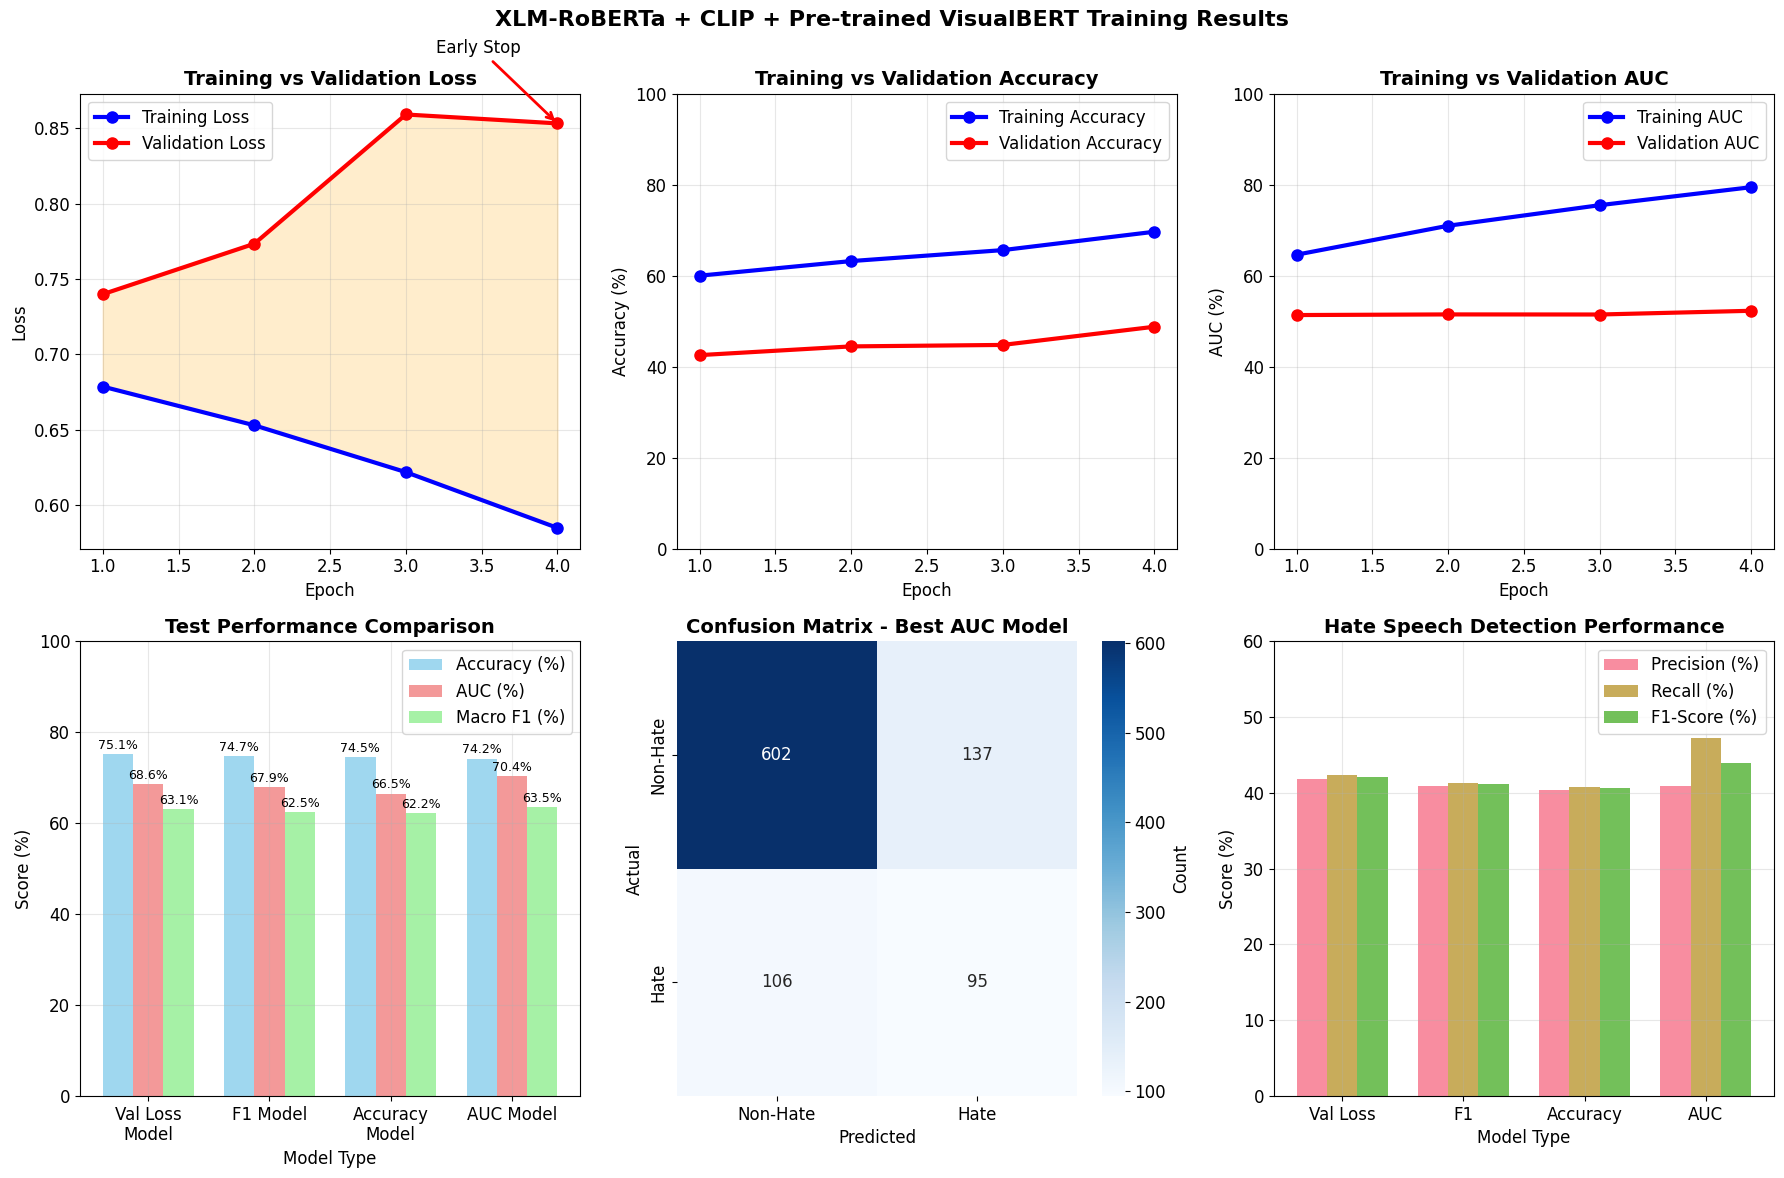

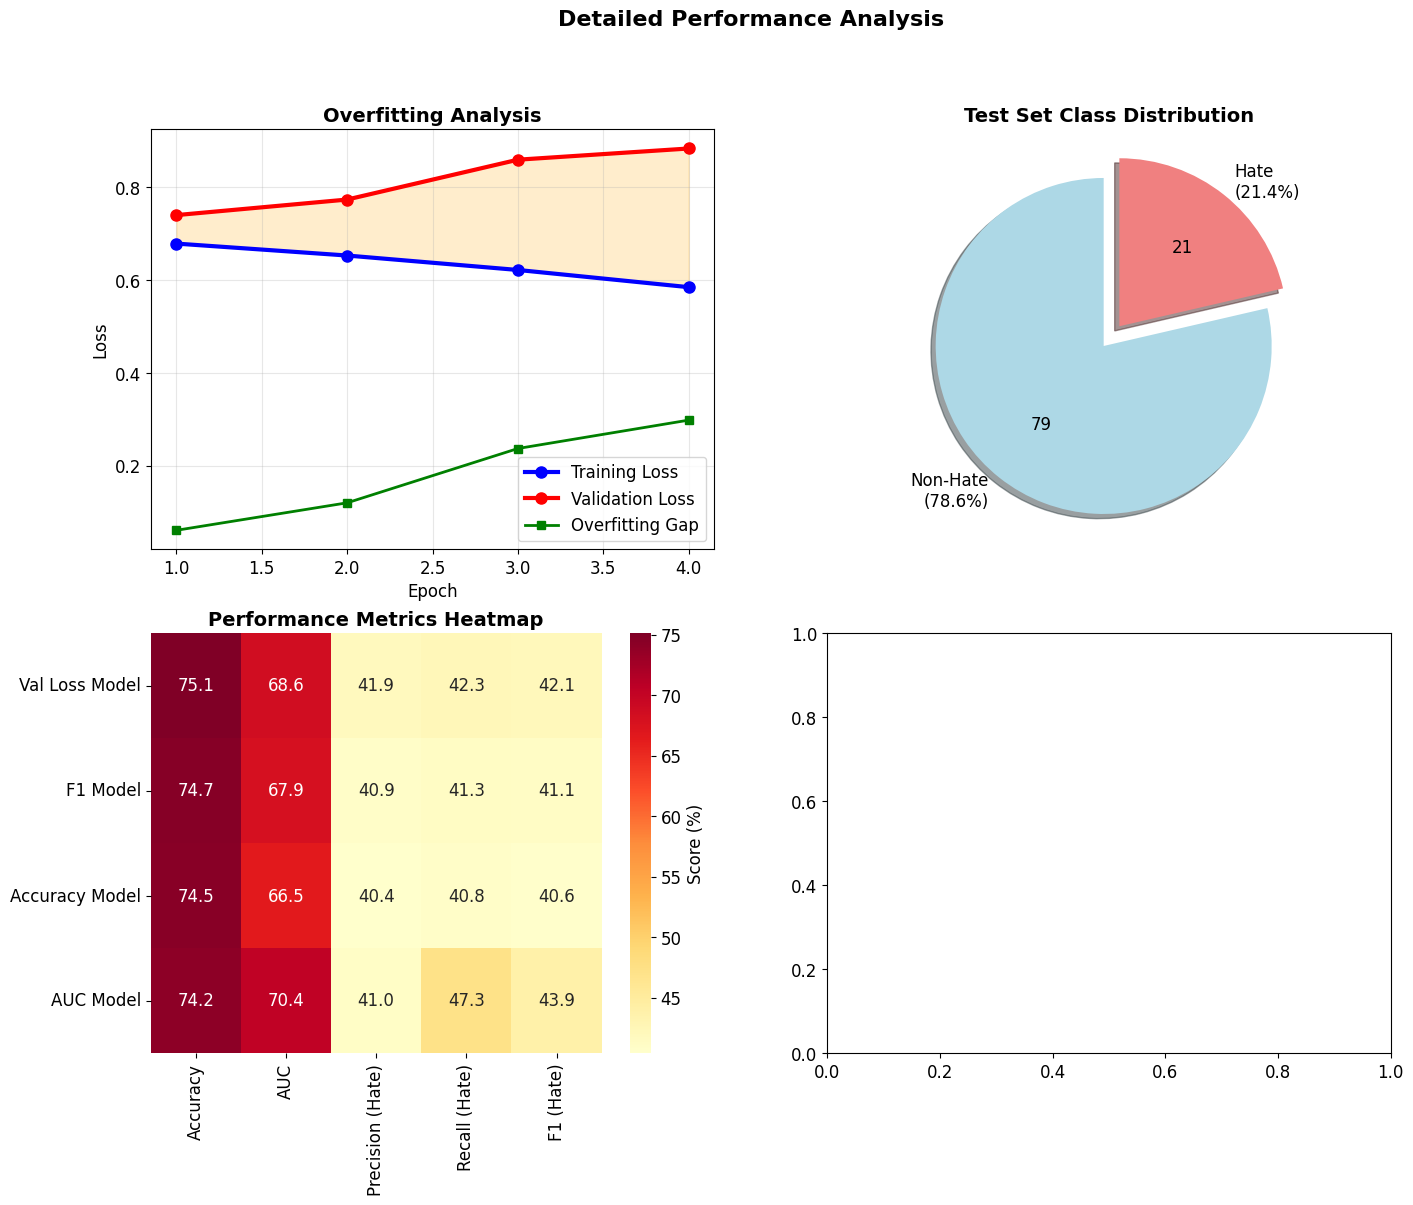

In [ ]:
#!/usr/bin/env python3

# Install required packages
"""
!pip install matplotlib seaborn pandas numpy scikit-learn
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Set style for beautiful plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

def plot_training_results():
    """Create comprehensive training plots"""


    epochs = [1, 2, 3, 4]
    train_loss = [0.6785, 0.6528, 0.6217, 0.5847]
    train_acc = [0.6001, 0.6322, 0.6563, 0.6967]
    train_auc = [0.6462, 0.7099, 0.7551, 0.7947]

    val_loss = [0.7398, 0.7733, 0.8591, 0.8532]
    val_acc = [0.4254, 0.4446, 0.4478, 0.4878]
    val_auc = [0.5135, 0.5149, 0.5147, 0.5229]
    val_f1 = [0.3379, 0.4017, 0.4104, 0.4203]

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('XLM-RoBERTa + CLIP + Pre-trained VisualBERT Training Results',
                 fontsize=16, fontweight='bold', y=0.98)

    # 1. Training vs Validation Loss
    axes[0, 0].plot(epochs, train_loss, 'b-o', label='Training Loss', linewidth=3, markersize=8)
    axes[0, 0].plot(epochs, val_loss, 'r-o', label='Validation Loss', linewidth=3, markersize=8)
    axes[0, 0].fill_between(epochs, train_loss, val_loss, alpha=0.2, color='orange')
    axes[0, 0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].annotate('Early Stop', xy=(4, val_loss[-1]), xytext=(3.2, 0.9),
                       arrowprops=dict(arrowstyle='->', color='red', lw=2))

    # 2. Training vs Validation Accuracy
    axes[0, 1].plot(epochs, [x*100 for x in train_acc], 'b-o', label='Training Accuracy', linewidth=3, markersize=8)
    axes[0, 1].plot(epochs, [x*100 for x in val_acc], 'r-o', label='Validation Accuracy', linewidth=3, markersize=8)
    axes[0, 1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 100)

    # 3. Training vs Validation AUC
    axes[0, 2].plot(epochs, [x*100 for x in train_auc], 'b-o', label='Training AUC', linewidth=3, markersize=8)
    axes[0, 2].plot(epochs, [x*100 for x in val_auc], 'r-o', label='Validation AUC', linewidth=3, markersize=8)
    axes[0, 2].set_title('Training vs Validation AUC', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('AUC (%)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim(0, 100)

    # 4. Model Performance Comparison
    models = ['Val Loss\nModel', 'F1 Model', 'Accuracy\nModel', 'AUC Model']
    accuracies = [75.11, 74.68, 74.47, 74.15]
    aucs = [68.60, 67.93, 66.48, 70.39]
    f1_scores = [63.11, 62.48, 62.17, 63.54]

    x = np.arange(len(models))
    width = 0.25

    bars1 = axes[1, 0].bar(x - width, accuracies, width, label='Accuracy (%)', alpha=0.8, color='skyblue')
    bars2 = axes[1, 0].bar(x, aucs, width, label='AUC (%)', alpha=0.8, color='lightcoral')
    bars3 = axes[1, 0].bar(x + width, f1_scores, width, label='Macro F1 (%)', alpha=0.8, color='lightgreen')

    axes[1, 0].set_title('Test Performance Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Model Type')
    axes[1, 0].set_ylabel('Score (%)')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(models)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0, 100)

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    # 5. Confusion Matrix (Best AUC Model)
    cm = np.array([[602, 137], [106, 95]])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                cbar_kws={'label': 'Count'})
    axes[1, 1].set_title('Confusion Matrix - Best AUC Model', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    # 6. Class Performance Analysis
    class_metrics = {
        'Non-Hate Speech': {
            'Precision': [84.26, 83.99, 83.85, 85.03],
            'Recall': [84.03, 83.76, 83.63, 81.46],
            'F1-Score': [84.15, 83.88, 83.74, 83.21]
        },
        'Hate Speech': {
            'Precision': [41.87, 40.89, 40.39, 40.95],
            'Recall': [42.29, 41.29, 40.80, 47.26],
            'F1-Score': [42.08, 41.09, 40.59, 43.88]
        }
    }

    models_short = ['Val Loss', 'F1', 'Accuracy', 'AUC']
    hate_precision = [41.87, 40.89, 40.39, 40.95]
    hate_recall = [42.29, 41.29, 40.80, 47.26]
    hate_f1 = [42.08, 41.09, 40.59, 43.88]

    x = np.arange(len(models_short))
    width = 0.25

    axes[1, 2].bar(x - width, hate_precision, width, label='Precision (%)', alpha=0.8)
    axes[1, 2].bar(x, hate_recall, width, label='Recall (%)', alpha=0.8)
    axes[1, 2].bar(x + width, hate_f1, width, label='F1-Score (%)', alpha=0.8)

    axes[1, 2].set_title('Hate Speech Detection Performance', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Model Type')
    axes[1, 2].set_ylabel('Score (%)')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(models_short)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_ylim(0, 60)

    plt.tight_layout()
    plt.show()

    return fig

def plot_detailed_analysis():
    """Create detailed analysis plots"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Detailed Performance Analysis', fontsize=16, fontweight='bold')

    # 1. Overfitting Analysis
    epochs = [1, 2, 3, 4]
    train_loss = [0.6785, 0.6528, 0.6217, 0.5847]
    val_loss = [0.7398, 0.7733, 0.8591, 0.8832]
    gap = [val_loss[i] - train_loss[i] for i in range(4)]

    axes[0, 0].plot(epochs, train_loss, 'b-o', label='Training Loss', linewidth=3, markersize=8)
    axes[0, 0].plot(epochs, val_loss, 'r-o', label='Validation Loss', linewidth=3, markersize=8)
    axes[0, 0].plot(epochs, gap, 'g-s', label='Overfitting Gap', linewidth=2, markersize=6)
    axes[0, 0].fill_between(epochs, train_loss, val_loss, alpha=0.2, color='orange')
    axes[0, 0].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Class Distribution
    labels = ['Non-Hate\n(78.6%)', 'Hate\n(21.4%)']
    sizes = [739, 201]
    colors = ['lightblue', 'lightcoral']
    explode = (0.05, 0.1)  # explode hate speech slice

    axes[0, 1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f',
                   shadow=True, startangle=90)
    axes[0, 1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')

    # 3. Performance Metrics Heatmap
    models = ['Val Loss Model', 'F1 Model', 'Accuracy Model', 'AUC Model']
    metrics = ['Accuracy', 'AUC', 'Precision (Hate)', 'Recall (Hate)', 'F1 (Hate)']

    performance_data = np.array([
        [75.11, 68.60, 41.87, 42.29, 42.08],  # Val Loss Model
        [74.68, 67.93, 40.89, 41.29, 41.09],  # F1 Model
        [74.47, 66.48, 40.39, 40.80, 40.59],  # Accuracy Model
        [74.15, 70.39, 40.95, 47.26, 43.88]   # AUC Model
    ])

    sns.heatmap(performance_data, annot=True, fmt='.1f', cmap='YlOrRd',
                xticklabels=metrics, yticklabels=models, ax=axes[1, 0],
                cbar_kws={'label': 'Score (%)'})
    axes[1, 0].set_title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')



    return fig



# Main execution
if __name__ == "__main__":
    print("Creating comprehensive training visualizations...")

    # Create all plots
    fig1 = plot_training_results()
    fig2 = plot_detailed_analysis()
    #create_summary_table()

